Author: Percy Brown

### Topic: Exploring the impact of Partial Layer Freezing of MLMs for PoS Tagging.

[DistilBert](https://huggingface.co/docs/transformers/en/model_doc/distilbert) is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

In this task, I will be exploring the impact of partial freezing of Multilingual Language Models for Part-of-Speech Tagging. I will fine-tune use the DistilBert on a dataset of English language from [Universal Dependecies](https://universaldependencies.org/). Afterwards, some layers of the model are freezed and the performance is compared with the baseline performance established earlier.

## Installing and Importing Relevant Libraries and Models




In [1]:
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.1.0+cu121'

# Task 1: Dataset Preparation and Baseline Model Training

## Data preparation and Pre-processing

The function below reads the dataset and transforms it into a list of lists, where each sublist represents a sentence or phrase. Each sublist is a list of tuples containing where each tuple contains a token and corresponding pos tag. The [datasets](https://github.com/PersieB/Partial-Freezing-for-PoS-tagging/tree/main) is divided into

*   Train set
*   Dev set
*   Test set



In [3]:
import requests

def read_data(file_url):
    response = requests.get(file_url)

    if response.status_code != 200:
        print("Failed to fetch data from URL:", file_url)
        return None

    data = response.text

    sentences = data.strip().split('\n\n')

    list_of_lists = []

    for sentence in sentences:
        tokens = sentence.split('\n')
        sublist = [(token.split('\t')[0], token.split('\t')[1]) for token in tokens]
        list_of_lists.append(sublist)

    return list_of_lists


## Loading Datasets

In [4]:
train_sentences = read_data("https://raw.githubusercontent.com/PersieB/Partial-Freezing-for-PoS-tagging/main/en-ud-tag.v2.train.txt")
dev_sentences = read_data("https://raw.githubusercontent.com/PersieB/Partial-Freezing-for-PoS-tagging/main/en-ud-tag.v2.dev.txt")
test_sentences = read_data("https://raw.githubusercontent.com/PersieB/Partial-Freezing-for-PoS-tagging/main/en-ud-tag.v2.test.txt")

In [5]:
train_sentences

[[('Al', 'PROPN'),
  ('-', 'PUNCT'),
  ('Zaman', 'PROPN'),
  (':', 'PUNCT'),
  ('American', 'ADJ'),
  ('forces', 'NOUN'),
  ('killed', 'VERB'),
  ('Shaikh', 'PROPN'),
  ('Abdullah', 'PROPN'),
  ('al', 'PROPN'),
  ('-', 'PUNCT'),
  ('Ani', 'PROPN'),
  (',', 'PUNCT'),
  ('the', 'DET'),
  ('preacher', 'NOUN'),
  ('at', 'ADP'),
  ('the', 'DET'),
  ('mosque', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('town', 'NOUN'),
  ('of', 'ADP'),
  ('Qaim', 'PROPN'),
  (',', 'PUNCT'),
  ('near', 'ADP'),
  ('the', 'DET'),
  ('Syrian', 'ADJ'),
  ('border', 'NOUN'),
  ('.', 'PUNCT')],
 [('[', 'PUNCT'),
  ('This', 'DET'),
  ('killing', 'NOUN'),
  ('of', 'ADP'),
  ('a', 'DET'),
  ('respected', 'ADJ'),
  ('cleric', 'NOUN'),
  ('will', 'AUX'),
  ('be', 'AUX'),
  ('causing', 'VERB'),
  ('us', 'PRON'),
  ('trouble', 'NOUN'),
  ('for', 'ADP'),
  ('years', 'NOUN'),
  ('to', 'PART'),
  ('come', 'VERB'),
  ('.', 'PUNCT'),
  (']', 'PUNCT')],
 [('DPA', 'PROPN'),
  (':', 'PUNCT'),
  ('Iraqi', 'ADJ'),
  ('authoriti

In [6]:
dev_sentences

[[('From', 'ADP'),
  ('the', 'DET'),
  ('AP', 'PROPN'),
  ('comes', 'VERB'),
  ('this', 'DET'),
  ('story', 'NOUN'),
  (':', 'PUNCT')],
 [('President', 'PROPN'),
  ('Bush', 'PROPN'),
  ('on', 'ADP'),
  ('Tuesday', 'PROPN'),
  ('nominated', 'VERB'),
  ('two', 'NUM'),
  ('individuals', 'NOUN'),
  ('to', 'PART'),
  ('replace', 'VERB'),
  ('retiring', 'VERB'),
  ('jurists', 'NOUN'),
  ('on', 'ADP'),
  ('federal', 'ADJ'),
  ('courts', 'NOUN'),
  ('in', 'ADP'),
  ('the', 'DET'),
  ('Washington', 'PROPN'),
  ('area', 'NOUN'),
  ('.', 'PUNCT')],
 [('Bush', 'PROPN'),
  ('nominated', 'VERB'),
  ('Jennifer', 'PROPN'),
  ('M.', 'PROPN'),
  ('Anderson', 'PROPN'),
  ('for', 'ADP'),
  ('a', 'DET'),
  ('15', 'NUM'),
  ('-', 'PUNCT'),
  ('year', 'NOUN'),
  ('term', 'NOUN'),
  ('as', 'ADP'),
  ('associate', 'ADJ'),
  ('judge', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('Superior', 'PROPN'),
  ('Court', 'PROPN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('District', 'PROPN'),
  ('of', 'ADP'),
  ('Columbi

In [7]:
test_sentences

[[('What', 'PRON'),
  ('if', 'SCONJ'),
  ('Google', 'PROPN'),
  ('Morphed', 'VERB'),
  ('Into', 'ADP'),
  ('GoogleOS', 'PROPN'),
  ('?', 'PUNCT')],
 [('What', 'PRON'),
  ('if', 'SCONJ'),
  ('Google', 'PROPN'),
  ('expanded', 'VERB'),
  ('on', 'ADP'),
  ('its', 'PRON'),
  ('search', 'NOUN'),
  ('-', 'PUNCT'),
  ('engine', 'NOUN'),
  ('(', 'PUNCT'),
  ('and', 'CCONJ'),
  ('now', 'ADV'),
  ('e-mail', 'NOUN'),
  (')', 'PUNCT'),
  ('wares', 'NOUN'),
  ('into', 'ADP'),
  ('a', 'DET'),
  ('full', 'ADV'),
  ('-', 'PUNCT'),
  ('fledged', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('?', 'PUNCT')],
 [('[', 'PUNCT'),
  ('via', 'ADP'),
  ('Microsoft', 'PROPN'),
  ('Watch', 'PROPN'),
  ('from', 'ADP'),
  ('Mary', 'PROPN'),
  ('Jo', 'PROPN'),
  ('Foley', 'PROPN'),
  (']', 'PUNCT')],
 [('(', 'PUNCT'),
  ('And', 'CCONJ'),
  (',', 'PUNCT'),
  ('by', 'ADP'),
  ('the', 'DET'),
  ('way', 'NOUN'),
  (',', 'PUNCT'),
  ('is', 'AUX'),
  ('anybody', 'PRON'),
  ('else', 'ADJ'),
  ('just', 'ADV'),
 

Extracting unique tags from a list of (word, part-of-speech) pairs in train_sentences. word_pos[1] refers to the part-of-speech tag which is the second element of each (word, part-of-speech) pair

In [8]:
tags = list(set(word_pos[1] for sent in train_sentences for word_pos in sent))

In [9]:
",".join(tags)

'PROPN,PRON,X,ADV,SCONJ,CCONJ,ADJ,NOUN,DET,VERB,PART,PUNCT,ADP,NUM,SYM,AUX,INTJ'

By convention, the 0'th slot is reserved for padding.

In [10]:
tags = ["<pad>"] + tags

Creating mappings between part-of-speech tags and their corresponding indices (tag2idx) and between indices and their corresponding part-of-speech tags (idx2tag). These mappings are crucial for converting between part-of-speech tags and their numerical representations.

In [11]:
tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}

Set the device to cuda or cpu depending on whether cuda-enabled GPU is available for faster execution

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Initializing the DistilBERT Tokenizer

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

 The class below adds special tokens "[CLS]" and "[SEP]" to the beginning and end of each sentence respectively as well as some padding, and returns the words, token IDs, first piece indicators, tags, tag IDs, and sequence length for the sentence

In [14]:
class PosDataset(data.Dataset):
    def __init__(self, train_sentences):
        sents, tags_li = [], [] # list of lists
        for sent in train_sentences:
            words = [word_pos[0] for word_pos in sent]
            tags = [word_pos[1] for word_pos in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen


The function below pads the input sequences in a batch to the length of the longest sequence within the batch.

In [15]:
def pad(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    is_heads = f(2)
    tags = f(3)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(1, maxlen)
    y = f(-2, maxlen)


    f = torch.LongTensor

    return words, f(x), is_heads, tags, f(y), seqlens

## Baseline Model Definition


Utilizing the DistilBERT model for token embeddings and a linear layer for classification.

In [16]:
class Net(nn.Module):
    def __init__(self, vocab_size=None):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        self.fc = nn.Linear(768, vocab_size)
        self.device = device

    def forward(self, x, y):
        '''
        x: (N, T). int64
        y: (N, T). int64
        '''
        x = x.to(device)
        y = y.to(device)

        if self.training:
            self.bert.train()
            encoded_layers = self.bert(x)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers = self.bert(x)
                enc = encoded_layers[-1]

        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat

## Training Function

This train function is responsible for training the provided neural network model using a given dataset, iterator, optimizer, and loss criterion.

In [17]:
def train(model, iterator, optimizer, criterion):
    model.train()
    losses = []  # To store losses for visualization
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        _y = y # for monitoring
        optimizer.zero_grad()
        logits, y, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)

        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))
            losses.append(loss.item())  # Store the loss for visualization
      # Plot the loss curve
    plt.plot(losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

## Evaluation Function

This eval function evaluates the performance of the provided model on a given dataset iterator. It computes predictions for the input data and then calculates evaluation metrics based on these predictions. Saves the results in a new file named ***baseline_results***

In [18]:
def eval(model, iterator, filename_to_save):
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch

            _, _, y_hat = model(x, y)  # y_hat: (N, T)

            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    ## gets results and save in a file
    with open(filename_to_save, 'w') as fout:
        for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
            y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
            preds = [idx2tag[hat] for hat in y_hat]
            assert len(preds)==len(words.split())==len(tags.split())
            for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                fout.write("{} {} {}\n".format(w, t, p))
            fout.write("\n")

    ## calc metric
    y_true =  np.array([tag2idx[line.split()[1]] for line in open(filename_to_save, 'r').read().splitlines() if len(line) > 0])
    y_pred =  np.array([tag2idx[line.split()[2]] for line in open(filename_to_save, 'r').read().splitlines() if len(line) > 0])

    acc = (y_true==y_pred).astype(np.int32).sum() / len(y_true)

    print("acc=%.2f"%acc)


## Baseline Model Initialization

Initializes a neural network model, moves it to the specified device for computation (CPU or GPU), and then wraps it with nn.DataParallel to leverage multiple GPUs if available

In [19]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

After initial training, the train set was too large and failed at a point, so I will use 70 percent of it to train. The function below shuffles the training data and picks 70% of it



In [20]:
import random

# Shuffle the data randomly
random.shuffle(train_sentences)

# Calculate 70% of the training data
split_index = int(0.7 * len(train_sentences))

# Use only 70%
train_sentences = train_sentences[:split_index]

Number of sentences were around 12,000 but i am using 70% of it due to time and memory constraints during training

In [21]:
len(train_sentences)

8780

## Data Loader

The code below sets up the training, validation, and test data iterators, as well as defining the optimizer and loss function.

In [22]:
train_dataset = PosDataset(train_sentences)
val_dataset = PosDataset(dev_sentences)
test_dataset = PosDataset(test_sentences)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
dev_iter = data.DataLoader(dataset=val_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

test_iter = data.DataLoader(dataset=test_dataset,
                             batch_size=8,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

## Training Phase for Baseline Model

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


step: 0, loss: 2.896130084991455
step: 10, loss: 2.3454747200012207
step: 20, loss: 1.8873291015625
step: 30, loss: 1.618746042251587
step: 40, loss: 1.418833613395691
step: 50, loss: 1.1893267631530762
step: 60, loss: 1.177929401397705
step: 70, loss: 0.8941200375556946
step: 80, loss: 0.9585885405540466
step: 90, loss: 1.0251319408416748
step: 100, loss: 1.0623408555984497
step: 110, loss: 0.6319136619567871
step: 120, loss: 0.9359479546546936
step: 130, loss: 0.94236159324646
step: 140, loss: 0.8904186487197876
step: 150, loss: 0.6466064453125
step: 160, loss: 0.8830697536468506
step: 170, loss: 0.7733966708183289
step: 180, loss: 0.744066059589386
step: 190, loss: 0.6885879039764404
step: 200, loss: 0.7320219278335571
step: 210, loss: 0.6502697467803955
step: 220, loss: 0.49137061834335327
step: 230, loss: 0.688458263874054
step: 240, loss: 0.7645508050918579
step: 250, loss: 0.7409285306930542
step: 260, loss: 0.7972902059555054
step: 270, loss: 0.5450178980827332
step: 280, loss:

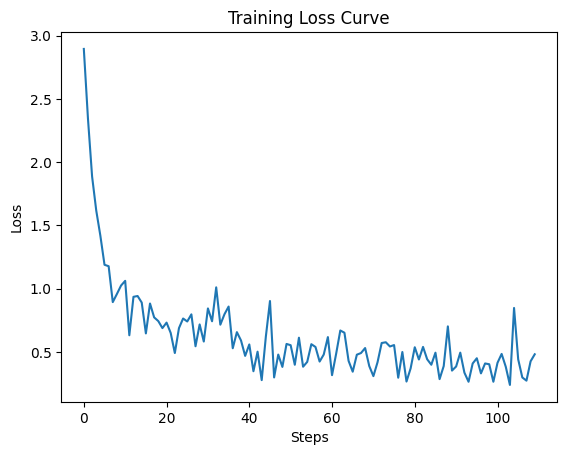

In [23]:
train(model, train_iter, optimizer, criterion)

## Evaluation with Dev (Validation) Set

In [24]:
eval(model, dev_iter, 'baseline_valset_results.txt')

acc=0.87


View baseline results on validation set.

In [25]:
open('baseline_valset_results.txt', 'r').read().splitlines()[:100]

['From ADP ADP',
 'the DET DET',
 'AP PROPN NOUN',
 'comes VERB VERB',
 'this DET DET',
 'story NOUN NOUN',
 ': PUNCT PUNCT',
 '',
 'President PROPN PROPN',
 'Bush PROPN PROPN',
 'on ADP ADP',
 'Tuesday PROPN PROPN',
 'nominated VERB VERB',
 'two NUM NUM',
 'individuals NOUN NOUN',
 'to PART PART',
 'replace VERB VERB',
 'retiring VERB NOUN',
 'jurists NOUN NOUN',
 'on ADP ADP',
 'federal ADJ ADJ',
 'courts NOUN NOUN',
 'in ADP ADP',
 'the DET DET',
 'Washington PROPN PROPN',
 'area NOUN NOUN',
 '. PUNCT PUNCT',
 '',
 'Bush PROPN PROPN',
 'nominated VERB PROPN',
 'Jennifer PROPN PROPN',
 'M. PROPN PROPN',
 'Anderson PROPN VERB',
 'for ADP ADP',
 'a DET DET',
 '15 NUM NUM',
 '- PUNCT PUNCT',
 'year NOUN NOUN',
 'term NOUN NOUN',
 'as ADP ADP',
 'associate ADJ VERB',
 'judge NOUN NOUN',
 'of ADP ADP',
 'the DET DET',
 'Superior PROPN ADJ',
 'Court PROPN PROPN',
 'of ADP ADP',
 'the DET DET',
 'District PROPN NOUN',
 'of ADP ADP',
 'Columbia PROPN PROPN',
 ', PUNCT PUNCT',
 'replacing VER

## Further Evaluation with Test Set

In [26]:
eval(model, test_iter, 'baseline_testset_results.txt')

acc=0.88


View baseline results on test set.



In [27]:
open('baseline_testset_results.txt', 'r').read().splitlines()[:100]

['What PRON PRON',
 'if SCONJ SCONJ',
 'Google PROPN PROPN',
 'Morphed VERB PROPN',
 'Into ADP PROPN',
 'GoogleOS PROPN PROPN',
 '? PUNCT PUNCT',
 '',
 'What PRON PRON',
 'if SCONJ SCONJ',
 'Google PROPN ADJ',
 'expanded VERB NOUN',
 'on ADP ADP',
 'its PRON PRON',
 'search NOUN NOUN',
 '- PUNCT PUNCT',
 'engine NOUN NOUN',
 '( PUNCT PUNCT',
 'and CCONJ CCONJ',
 'now ADV ADV',
 'e-mail NOUN NOUN',
 ') PUNCT PUNCT',
 'wares NOUN NOUN',
 'into ADP ADP',
 'a DET DET',
 'full ADV ADJ',
 '- PUNCT PUNCT',
 'fledged ADJ NOUN',
 'operating NOUN NOUN',
 'system NOUN NOUN',
 '? PUNCT PUNCT',
 '',
 '[ PUNCT PUNCT',
 'via ADP ADP',
 'Microsoft PROPN PROPN',
 'Watch PROPN NOUN',
 'from ADP ADP',
 'Mary PROPN PROPN',
 'Jo PROPN PROPN',
 'Foley PROPN PROPN',
 '] PUNCT PUNCT',
 '',
 '( PUNCT PUNCT',
 'And CCONJ CCONJ',
 ', PUNCT PUNCT',
 'by ADP ADP',
 'the DET DET',
 'way NOUN NOUN',
 ', PUNCT PUNCT',
 'is AUX AUX',
 'anybody PRON VERB',
 'else ADJ ADJ',
 'just ADV ADV',
 'a DET DET',
 'little ADJ AD

# Task 2: Model Adjustment and Partial Freezing

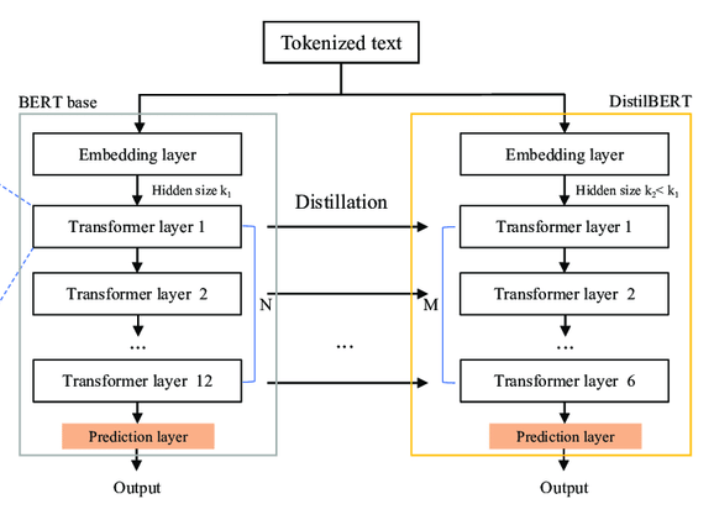



From the diagram above, I have realised that there are differences in the model architecture between a BERT and a DistilBERT model. For instance, the BERT has 12 transformer models while the DistilBERT has 6 models.

### Embedding Layer

Since the downstream task I am working on is the PoS tagging, I attempt to fine-tune the embedding layer since the task is similar to other tasks performed by the DistilBert such as text classification. Fine-tuning it will also allow the model to adapt its word representations to the specific characteristics of the PoS tagging task.

## Transformer Layers

I attempt to freeze the first 3 layers of the transformer layers as they are most likely going to capture low-level features, word relationships and language patterns, which are likely applicable to many downstream tasks, of which PoS tagging could be a beneficiary.

## Frozen Model Definition

Unlike the Baseline Model, I freeze the first 3 transformer layers in the model architecture.

In [28]:
class Frozen_Net(nn.Module):
    def __init__(self, vocab_size=None):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze the first 3 transformer layers
        for param in self.bert.transformer.layer[:3].parameters():
            param.requires_grad = False

        self.fc = nn.Linear(768, vocab_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)

        if self.training:
            self.bert.train()
            encoded_layers = self.bert(x)
            enc = encoded_layers.last_hidden_state
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers = self.bert(x)
                enc = encoded_layers.last_hidden_state

        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat

## Frozen Model Initialization

In [29]:
frozen_model = Frozen_Net(vocab_size=len(tag2idx))
frozen_model.to(device)
frozen_model = nn.DataParallel(frozen_model)

Defining the optimizer and loss function for the frozen model.

In [30]:
optimizer = optim.Adam(frozen_model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

## Training of Frozen Model on Training Data

step: 0, loss: 2.9005191326141357
step: 10, loss: 2.4378151893615723
step: 20, loss: 1.9372638463974
step: 30, loss: 1.8309822082519531
step: 40, loss: 1.808749794960022
step: 50, loss: 1.6814459562301636
step: 60, loss: 1.4294151067733765
step: 70, loss: 1.3397769927978516
step: 80, loss: 1.474465250968933
step: 90, loss: 1.5239737033843994
step: 100, loss: 1.2823032140731812
step: 110, loss: 0.8457058072090149
step: 120, loss: 1.1131834983825684
step: 130, loss: 1.0554018020629883
step: 140, loss: 1.2446105480194092
step: 150, loss: 0.8483994007110596
step: 160, loss: 1.0391713380813599
step: 170, loss: 0.898989737033844
step: 180, loss: 0.9275659918785095
step: 190, loss: 0.7230098247528076
step: 200, loss: 0.9018359780311584
step: 210, loss: 0.7098236083984375
step: 220, loss: 0.7115750908851624
step: 230, loss: 0.721691906452179
step: 240, loss: 0.5790097713470459
step: 250, loss: 0.7127612233161926
step: 260, loss: 1.1078648567199707
step: 270, loss: 0.7452253103256226
step: 280,

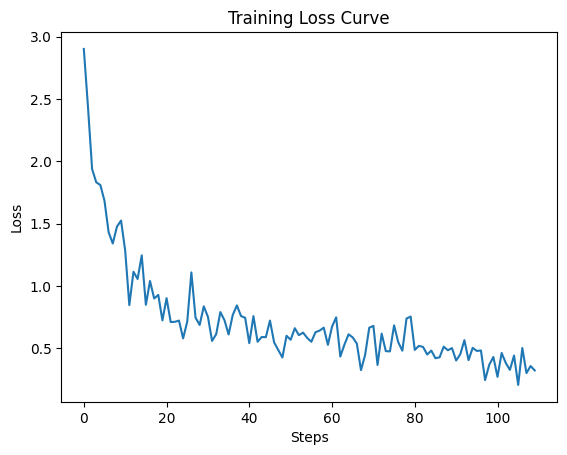

In [31]:
train(frozen_model, train_iter, optimizer, criterion)

Evaluation with dev set

In [32]:
eval(frozen_model, dev_iter, 'frozen_valset_results.txt')

acc=0.85


Evaluation with test set

In [33]:
eval(frozen_model, test_iter, 'frozen_testset_results.txt')

acc=0.86


Visualizing the Accuracy of both models

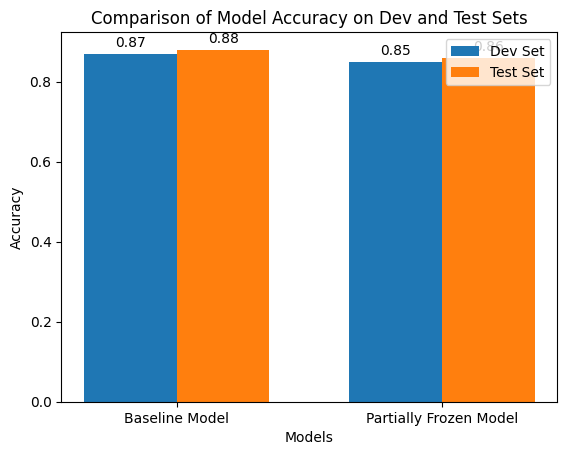

In [35]:
import matplotlib.pyplot as plt

# Define the model names
model_names = ['Baseline Model', 'Partially Frozen Model']

# Define the accuracy values for dev and test sets
dev_accuracy = [0.87, 0.85]
test_accuracy = [0.88, 0.86]

# Define the index for the bars
x = range(len(model_names))

# Set the width of the bars
width = 0.35

# Plot the grouped bar plot
fig, ax = plt.subplots()
dev_bars = ax.bar(x, dev_accuracy, width, label='Dev Set')
test_bars = ax.bar([p + width for p in x], test_accuracy, width, label='Test Set')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Accuracy on Dev and Test Sets')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(model_names)
ax.legend()

# Add values on top of the bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(dev_bars)
add_values(test_bars)

# Show the plot
plt.show()
